###Loading Library

In [1]:
# pandas
import pandas as pd

# numpy
import numpy as np

# defaultcit
from collections import defaultdict

# plot with folium
import folium
from IPython.core.display import HTML

# parsing time
from datetime import datetime, timedelta

# plotting with matplotlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# plotting with pylab
import pylab as P

# Clustering
from sklearn.cluster import MiniBatchKMeans, KMeans
import time
import json

# change prediction categories into labels
from sklearn import preprocessing
from sklearn import cross_validation 
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import re

###Loading Training/Testing Data

In [2]:
#test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")
train_df = train_df.sample(n = 50000, random_state = 666)

In [3]:
train_df = pd.DataFrame(train_df)
train_df = train_df.reset_index(drop=True)
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2003-04-02 13:00:00,ASSAULT,THREATS AGAINST LIFE,Wednesday,PARK,NONE,500 Block of CORBETT AV,-122.444182,37.757346
1,2011-12-15 16:15:00,LARCENY/THEFT,GRAND THEFT PICKPOCKET,Thursday,CENTRAL,NONE,300 Block of BAY ST,-122.412804,37.805774
2,2015-03-04 01:55:00,LARCENY/THEFT,GRAND THEFT FROM PERSON,Wednesday,MISSION,NONE,400 Block of CASTRO ST,-122.435150,37.761760
3,2008-08-19 22:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,NORTHERN,NONE,2000 Block of WASHINGTON ST,-122.427007,37.792582
4,2014-04-16 12:58:00,DRUG/NARCOTIC,SALE OF BASE/ROCK COCAINE,Wednesday,TENDERLOIN,"ARREST, BOOKED",TURK ST / HYDE ST,-122.415695,37.782585


In [4]:
#Look at the shape
train_df.shape

(50000, 9)

In [5]:
train_df.columns, train_df.dtypes

(Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
        'Resolution', 'Address', 'X', 'Y'],
       dtype='object'), Dates          object
 Category       object
 Descript       object
 DayOfWeek      object
 PdDistrict     object
 Resolution     object
 Address        object
 X             float64
 Y             float64
 dtype: object)

In [6]:
#Listing Unique values for columns
pd.unique(train_df.PdDistrict.ravel()), pd.unique(train_df.DayOfWeek.ravel()), pd.unique(train_df.Category.ravel()),\
pd.unique(train_df.Resolution .ravel())
#pd.unique(train_df.hour_of_day.ravel())

(array(['PARK', 'CENTRAL', 'MISSION', 'NORTHERN', 'TENDERLOIN', 'INGLESIDE',
        'TARAVAL', 'SOUTHERN', 'BAYVIEW', 'RICHMOND'], dtype=object),
 array(['Wednesday', 'Thursday', 'Tuesday', 'Friday', 'Saturday', 'Monday',
        'Sunday'], dtype=object),
 array(['ASSAULT', 'LARCENY/THEFT', 'DRUG/NARCOTIC', 'VEHICLE THEFT',
        'ROBBERY', 'WARRANTS', 'BURGLARY', 'SEX OFFENSES FORCIBLE',
        'VANDALISM', 'OTHER OFFENSES', 'PROSTITUTION', 'NON-CRIMINAL',
        'MISSING PERSON', 'TRESPASS', 'SUSPICIOUS OCC', 'WEAPON LAWS',
        'FORGERY/COUNTERFEITING', 'FRAUD', 'DISORDERLY CONDUCT',
        'SEX OFFENSES NON FORCIBLE', 'SECONDARY CODES',
        'DRIVING UNDER THE INFLUENCE', 'DRUNKENNESS', 'RUNAWAY', 'GAMBLING',
        'RECOVERED VEHICLE', 'STOLEN PROPERTY', 'LOITERING', 'KIDNAPPING',
        'EMBEZZLEMENT', 'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS',
        'BAD CHECKS', 'BRIBERY', 'SUICIDE', 'EXTORTION',
        'PORNOGRAPHY/OBSCENE MAT'], dtype=object),
 array(['NONE',

In [7]:
# dtDate = datetime.strptime("07-27-2012","%m-%d-%Y")
datetime.strptime('2015-05-13 23:53:00', "%Y-%m-%d %H:%M:%S")

datetime.datetime(2015, 5, 13, 23, 53)

###Getting Month of Year, Day of Month, Hour of Day, and Minute of Hour

In [8]:
## CHANGED temp, temp1, temp2, temp3 to match month_of_year, etc. since was throwing error

type(train_df.Dates.values[0])
month_of_year = []
day_of_month =[]
hour_of_day =[]
min_of_hour =[]
for i in range(len(train_df.Dates.values)):
#     print(i)
    moy = datetime.strptime(train_df.Dates.values[i], "%Y-%m-%d %H:%M:%S").month
    dom = datetime.strptime(train_df.Dates.values[i], "%Y-%m-%d %H:%M:%S").day
    hod = datetime.strptime(train_df.Dates.values[i], "%Y-%m-%d %H:%M:%S").hour
    moh = datetime.strptime(train_df.Dates.values[i], "%Y-%m-%d %H:%M:%S").minute
    month_of_year.append(moy)
    day_of_month.append(dom)
    hour_of_day.append(hod)
    min_of_hour.append(moh)
train_df['month_of_year'] = month_of_year
train_df['day_of_month'] = day_of_month
train_df['hour_of_day'] = hour_of_day
train_df['min_of_hour'] = min_of_hour

###Creating Weekday/Weekend Column

In [9]:
train_df['WeekdayWeeekend'] = train_df['DayOfWeek'].map( {'Monday': 'Weekday', 'Tuesday': 'Weekday', \
                                                          'Wednesday': 'Weekday', 'Thursday': 'Weekday', 'Friday': 'Weekend',\
                                                         'Saturday': 'Weekend', 'Sunday': 'Weekday'} ).astype(object)

### Creating Midnight/Morning/Afternoon/Night Column

In [10]:
train_df['TimeOfDay'] = train_df['hour_of_day'].map({0: 'Midnight', 1: 'Midnight', 2:'Midnight', 3:'Midnight', 4:'Morning', \
                                                     5:'Morning', 6:'Morning', 7:'Morning', 8:'Morning', 9:'Morning', \
                                                     10:'Morning', 11:'Morning', 12:'Afternoon', 13:'Afternoon', 14:'Afternoon', \
                                                     15:'Afternoon', 16:'Afternoon', 17:'Afternoon', 18:'Night', 19:'Night', \
                                                     20:'Night', 21:'Night', 22:'Midnight', 23:'Midnight'}).astype(object)

###Creating Season Column

In [11]:
train_df['Season'] = train_df['month_of_year'].map({1: 'Winter', 2: 'Winter', 3:'Spring', 4:'Spring', 5:'Spring', \
                                                     6:'Spring', 7:'Summer', 8:'Summer', 9:'Summer', 10:'Autumn', \
                                                     11:'Autumn', 12:'Winter'}).astype(object)

In [12]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,month_of_year,day_of_month,hour_of_day,min_of_hour,WeekdayWeeekend,TimeOfDay,Season
0,2003-04-02 13:00:00,ASSAULT,THREATS AGAINST LIFE,Wednesday,PARK,NONE,500 Block of CORBETT AV,-122.444182,37.757346,4,2,13,0,Weekday,Afternoon,Spring
1,2011-12-15 16:15:00,LARCENY/THEFT,GRAND THEFT PICKPOCKET,Thursday,CENTRAL,NONE,300 Block of BAY ST,-122.412804,37.805774,12,15,16,15,Weekday,Afternoon,Winter
2,2015-03-04 01:55:00,LARCENY/THEFT,GRAND THEFT FROM PERSON,Wednesday,MISSION,NONE,400 Block of CASTRO ST,-122.435150,37.761760,3,4,1,55,Weekday,Midnight,Spring
3,2008-08-19 22:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,NORTHERN,NONE,2000 Block of WASHINGTON ST,-122.427007,37.792582,8,19,22,0,Weekday,Midnight,Summer
4,2014-04-16 12:58:00,DRUG/NARCOTIC,SALE OF BASE/ROCK COCAINE,Wednesday,TENDERLOIN,"ARREST, BOOKED",TURK ST / HYDE ST,-122.415695,37.782585,4,16,12,58,Weekday,Afternoon,Spring


###Some Basic Visual just to look at the data

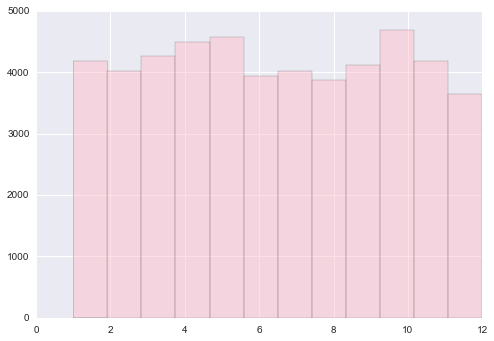

In [17]:
train_df['month_of_year'].hist(color = 'pink', alpha = .5, bins = 12, range = (1,12))
P.show()

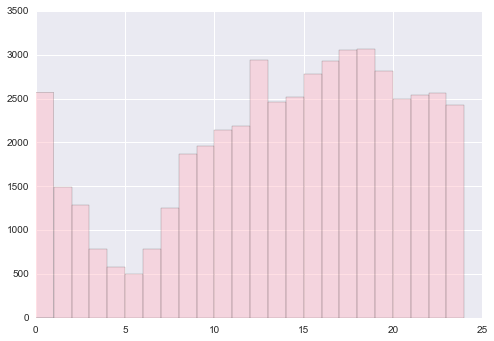

In [14]:
train_df['hour_of_day'].hist(color = 'pink', alpha = .5, bins = 24, range = (0,24))
P.show()

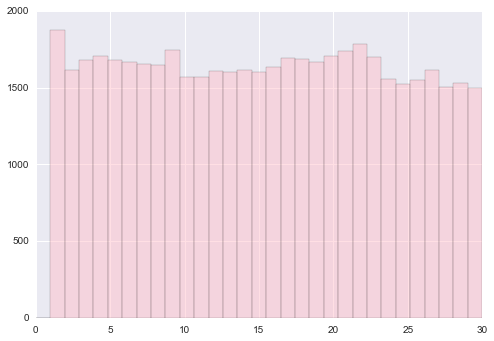

In [16]:
train_df['day_of_month'].hist(color = 'pink', alpha = .5, bins = 31, range = (0,30))
P.show()

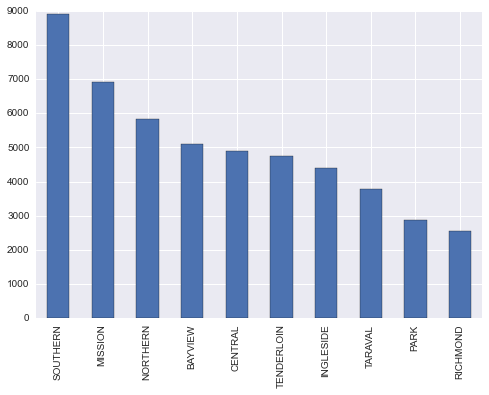

In [22]:
train_df['PdDistrict'].value_counts().plot(kind='bar')

# train_df['PdDistrict'].hist(color = 'pink', alpha = .5)
# P.show()

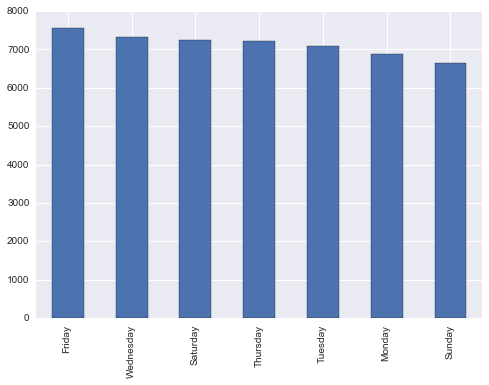

In [23]:
train_df['DayOfWeek'].value_counts().plot(kind='bar')

###Crime versus Time of Day (Morning, Afternoon, Night, Midnight)

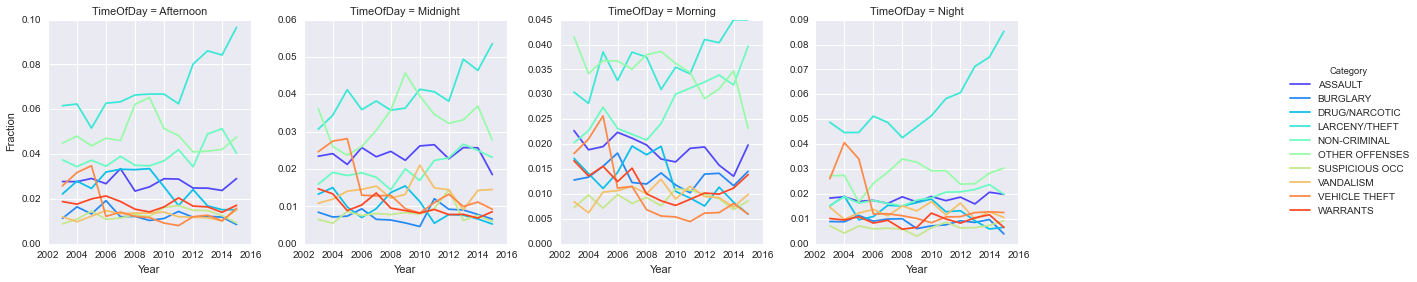

In [34]:
def parse_date(date):
    mo=re.search(r'^([0-9]{4})-([0-9]{2})-[0-9]{2}\s+([0-9]{2}):[0-9]{2}:[0-9]{2}$',date)
    return map(int,(mo.group(1),mo.group(2),mo.group(3)))
# Extract 'Year', 'Month' and 'Hour' columns for later use
month_dict={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
train_df['Year'],train_df['Month'],train_df['Hour']=zip(*train_df.loc[:,'Dates'].map(parse_date))

# Note here the subplots are based on columns, each column a new subplot
# Now let's look at the crime trend by year for each district. We have three features: 'Year', 'Category' and 'PdDistrict'. For each 'PdDistrict' and 'Year', we would like to see the crime composition instead of simply counts, since data are incomplete for 2015

by_hour_for_months=sns.FacetGrid(most_common, hue='Category', col='TimeOfDay', col_wrap=5, sharex=True, sharey=False, size=4,\
                        aspect=0.9, palette='rainbow')
by_hour_for_months=by_hour_for_months.map(plt.plot,'Year','Fraction').add_legend()
plt.savefig('Crime_Trend_in_Time_of_Day.png')

###Crime versus Weekend/Weeday

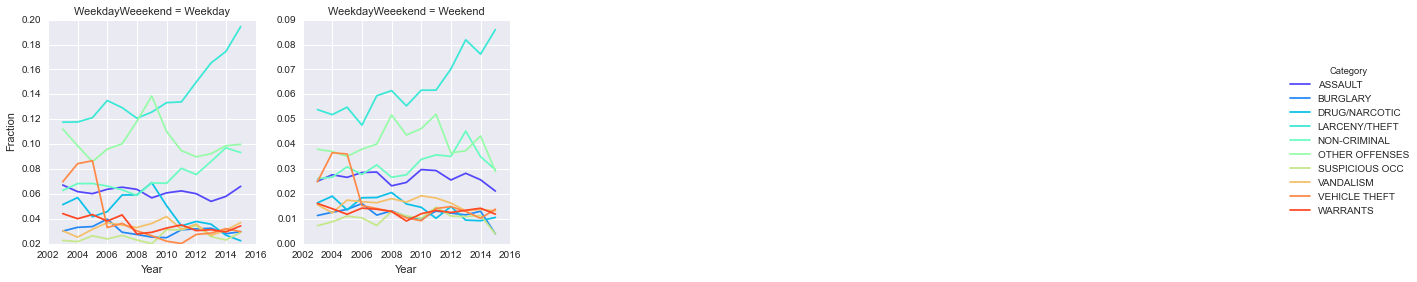

In [35]:
# Now let's look at the crime trend by year for each district. We have three features: 'Year', 'Category' and 'PdDistrict'. For each 'PdDistrict' and 'Year', we would like to see the crime composition instead of simply counts, since data are incomplete for 2015
freq_by_d_c=pd.pivot_table(train_df[['WeekdayWeeekend','Category','Year','Dates']],values='Dates',columns=('Year'),index=('WeekdayWeeekend','Category'),aggfunc='count')
freq_by_d_c=freq_by_d_c.fillna(0).apply(lambda x: x/np.sum(x))
freq_by_d_c=freq_by_d_c.stack()
freq_by_d_c=freq_by_d_c.reset_index()
freq_by_d_c=freq_by_d_c.rename(columns={0:'Fraction'})
most_common=freq_by_d_c[freq_by_d_c['Category'].isin(train_df['Category'].value_counts().head(10).index)]

by_hour_for_months=sns.FacetGrid(most_common, hue='Category', col='WeekdayWeeekend', col_wrap=5, sharex=True, sharey=False, size=4,\
                        aspect=0.9, palette='rainbow')
by_hour_for_months=by_hour_for_months.map(plt.plot,'Year','Fraction').add_legend()
plt.savefig('Crime_Trend_in_Weekend_Weekday.png')

###Crime versus Season(Spring/Summer/Winter/Autumn)

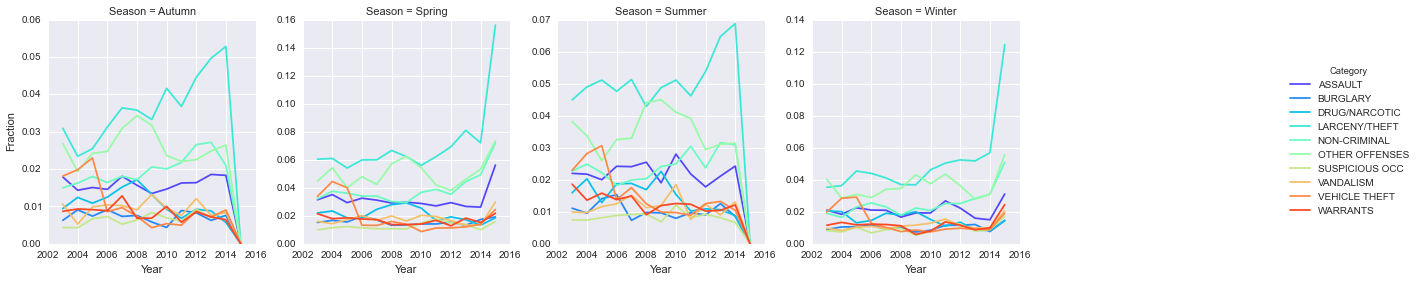

In [36]:
# Now let's look at the crime trend by year for each district. We have three features: 'Year', 'Category' and 'PdDistrict'. For each 'PdDistrict' and 'Year', we would like to see the crime composition instead of simply counts, since data are incomplete for 2015
freq_by_d_c=pd.pivot_table(train_df[['Season','Category','Year','Dates']],values='Dates',columns=('Year'),index=('Season','Category'),aggfunc='count')
freq_by_d_c=freq_by_d_c.fillna(0).apply(lambda x: x/np.sum(x))
freq_by_d_c=freq_by_d_c.stack()
freq_by_d_c=freq_by_d_c.reset_index()
freq_by_d_c=freq_by_d_c.rename(columns={0:'Fraction'})
most_common=freq_by_d_c[freq_by_d_c['Category'].isin(train_df['Category'].value_counts().head(10).index)]

by_hour_for_months=sns.FacetGrid(most_common, hue='Category', col='Season', col_wrap=5, sharex=True, sharey=False, size=4,\
                        aspect=0.9, palette='rainbow')
by_hour_for_months=by_hour_for_months.map(plt.plot,'Year','Fraction').add_legend()
plt.savefig('Crime_Trend_in_Season.png')

###Distribution of Crime by Hour in different months

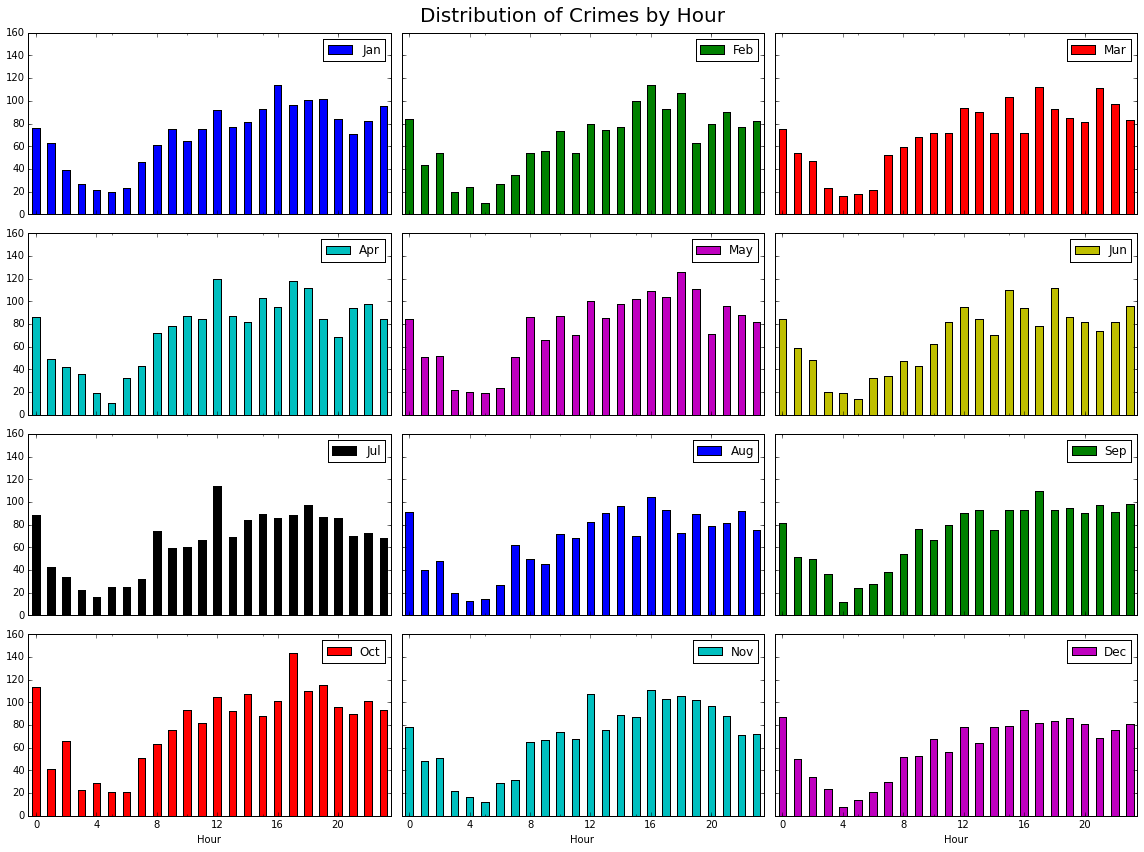

In [21]:
# We can first visualize the distribution of crimes over a day (by hours) in different months:
import re
def parse_date(date):
    mo=re.search(r'^([0-9]{4})-([0-9]{2})-[0-9]{2}\s+([0-9]{2}):[0-9]{2}:[0-9]{2}$',date)
    return map(int,(mo.group(1),mo.group(2),mo.group(3)))

# Extract 'Year', 'Month' and 'Hour' columns for later use
month_dict={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
train_df['Year'],train_df['Month'],train_df['Hour']=zip(*train_df.loc[:,'Dates'].map(parse_date))

data_month_hour=pd.crosstab(train_df['Hour'],train_df['Month'])
axhandles=data_month_hour.plot(kind='bar',subplots=True,layout=(4,3),figsize=(16,12),sharex=True,sharey=True,xticks=range(0,24,4),rot=0)

# Note here the subplots are based on columns, each column a new subplot
i=1
for axrow in axhandles:
    for ax in axrow:
        ax.set_xticklabels(range(0,24,4))
        ax.legend([month_dict[i]],loc='best')
        # Note here the argument has to be a list or a tuple, e.g. (month_dict[i],).
        # From Matplotlib official documentation: To make a legend for lines which already exist on the axes (via plot for instance),
        #    simply call this function with an ITERABLE of strings, one for each legend item.
        ax.set_title("")
        i+=1
plt.suptitle('Distribution of Crimes by Hour',size=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig('Distribution_of_Crimes_by_Hour.png')
#source: https://www.kaggle.com/lllinger/sf-crime/crimedistribution-temporal-spatial/code

###Distribution of Ten Most Common Crimes in Each District

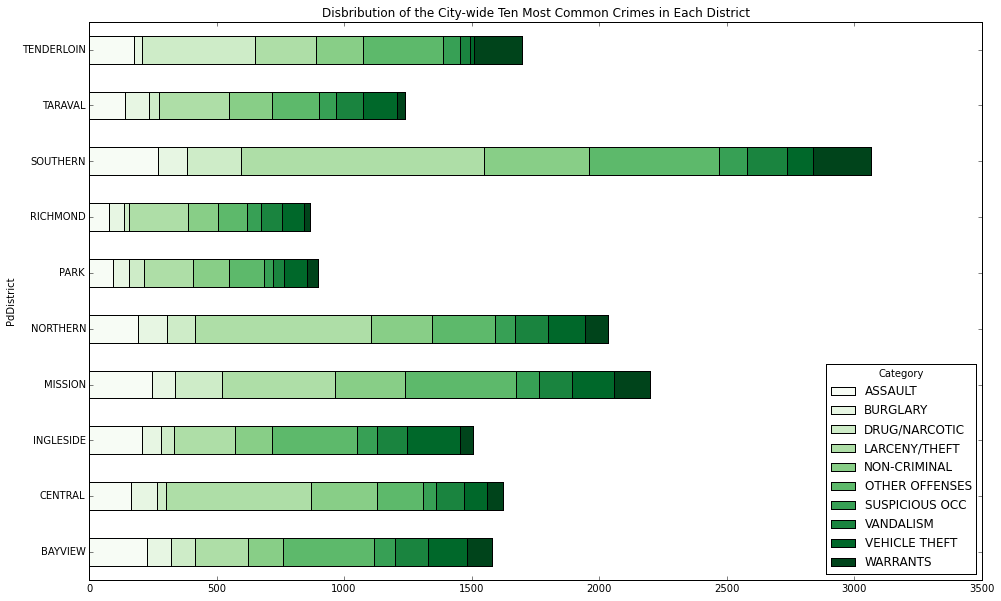

In [22]:
# Next, let's explore the spatial distribution of crimes. We can create a simple crosstab table and look at the count distribution
# Let's try to look at the city-wide 10 most common crimes in SF and a breakdown by district

ten_most_common=train_df[train_df['Category'].isin(train_df['Category'].value_counts().head(10).index)]

ten_most_crime_by_district=pd.crosstab(ten_most_common['PdDistrict'],ten_most_common['Category'])
ten_most_crime_by_district.plot(kind='barh',figsize=(16,10),stacked=True,colormap='Greens',title='Disbribution of the City-wide Ten Most Common Crimes in Each District')
plt.savefig('Disbribution_of_the_City-wide_Ten_Most_Common_Crimes_in_Each_District.png')
#source: https://www.kaggle.com/lllinger/sf-crime/crimedistribution-temporal-spatial/code

###Crime Trend By Year and District

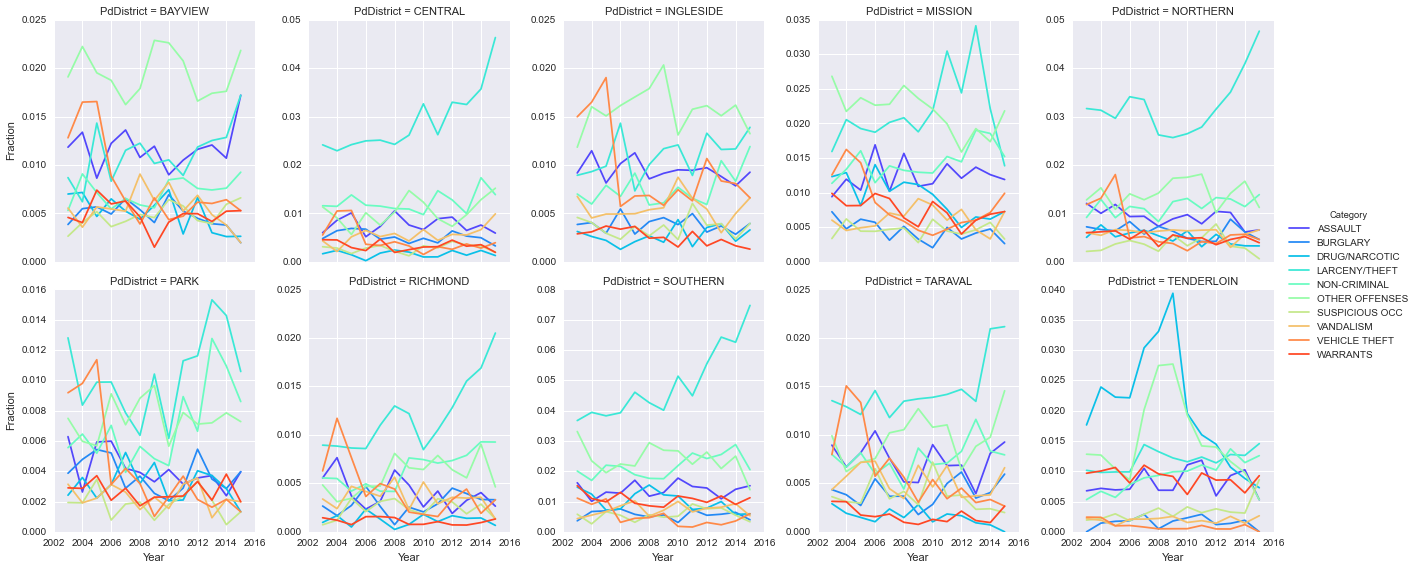

In [37]:
# Now let's look at the crime trend by year for each district. We have three features: 'Year', 'Category' and 'PdDistrict'. For each 'PdDistrict' and 'Year', we would like to see the crime composition instead of simply counts, since data are incomplete for 2015
freq_by_d_c=pd.pivot_table(train_df[['PdDistrict','Category','Year','Dates']],values='Dates',columns=('Year'),index=('PdDistrict','Category'),aggfunc='count')
freq_by_d_c=freq_by_d_c.fillna(0).apply(lambda x: x/np.sum(x))
freq_by_d_c=freq_by_d_c.stack()
freq_by_d_c=freq_by_d_c.reset_index()
freq_by_d_c=freq_by_d_c.rename(columns={0:'Fraction'})
most_common=freq_by_d_c[freq_by_d_c['Category'].isin(train_df['Category'].value_counts().head(10).index)]

by_hour_for_months=sns.FacetGrid(most_common, hue='Category', col='PdDistrict', col_wrap=5, sharex=True, sharey=False, size=4,\
                        aspect=0.9, palette='rainbow')
by_hour_for_months=by_hour_for_months.map(plt.plot,'Year','Fraction').add_legend()
plt.savefig('Crime_Trend_in_Each_District.png')
#source: https://www.kaggle.com/lllinger/sf-crime/crimedistribution-temporal-spatial/code

### Creating new data frame to get all new features

In [46]:
WeekdayWeekend_dummies = pd.get_dummies(train_df.WeekdayWeeekend)
TimeOfDay_dummies = pd.get_dummies(train_df.TimeOfDay)
season_dummies = pd.get_dummies(train_df.Season)
district_dummies = pd.get_dummies(train_df.PdDistrict)
week_dummies = pd.get_dummies(train_df.DayOfWeek)

train_df_new = pd.concat([train_df, WeekdayWeekend_dummies, TimeOfDay_dummies, season_dummies, district_dummies, week_dummies], axis=1, join_axes=[train_df.index])
print(train_df.shape)
print(WeekdayWeekend_dummies.shape)
print(TimeOfDay_dummies.shape)
print(season_dummies.shape)
print(district_dummies.shape)
print(week_dummies.shape)
print(train_df_new.shape)

(20000, 19)
(20000, 2)
(20000, 4)
(20000, 4)
(20000, 10)
(20000, 7)
(20000, 46)


In [47]:
le_crime = preprocessing.LabelEncoder()
crime = le_crime.fit_transform(train_df_new.Category)
train_df_new['dummy_Category'] = crime
train_df_new.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,month_of_year,...,TARAVAL,TENDERLOIN,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,dummy_Category
0,2003-04-02 13:00:00,ASSAULT,THREATS AGAINST LIFE,Wednesday,PARK,NONE,500 Block of CORBETT AV,-122.444182,37.757346,4,...,0,0,0,0,0,0,0,0,1,1
1,2011-12-15 16:15:00,LARCENY/THEFT,GRAND THEFT PICKPOCKET,Thursday,CENTRAL,NONE,300 Block of BAY ST,-122.412804,37.805774,12,...,0,0,0,0,0,0,1,0,0,16
2,2015-03-04 01:55:00,LARCENY/THEFT,GRAND THEFT FROM PERSON,Wednesday,MISSION,NONE,400 Block of CASTRO ST,-122.435150,37.761760,3,...,0,0,0,0,0,0,0,0,1,16
3,2008-08-19 22:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,NORTHERN,NONE,2000 Block of WASHINGTON ST,-122.427007,37.792582,8,...,0,0,0,0,0,0,0,1,0,16
4,2014-04-16 12:58:00,DRUG/NARCOTIC,SALE OF BASE/ROCK COCAINE,Wednesday,TENDERLOIN,"ARREST, BOOKED",TURK ST / HYDE ST,-122.415695,37.782585,4,...,0,1,0,0,0,0,0,0,1,7


In [48]:
train_df_new.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y', 'month_of_year', 'day_of_month',
       'hour_of_day', 'min_of_hour', 'WeekdayWeeekend', 'TimeOfDay', 'Season',
       'Year', 'Month', 'Hour', 'Weekday', 'Weekend', 'Afternoon', 'Midnight',
       'Morning', 'Night', 'Autumn', 'Spring', 'Summer', 'Winter', 'BAYVIEW',
       'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND',
       'SOUTHERN', 'TARAVAL', 'TENDERLOIN', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dummy_Category'],
      dtype='object')

In [49]:
# categories = list(raw_sfpd.Category.unique())
# print(categories)

In [50]:
# counts = dict()
# for i in items:
#   counts[i] = counts.get(i, 0) + 1
categories_dict = defaultdict(int)
for item in train_df_new.Category:
    categories_dict[item] += 1
    
(sorted(categories_dict.items(), key=lambda x: x[1], reverse=True))

[('LARCENY/THEFT', 4043),
 ('OTHER OFFENSES', 2805),
 ('NON-CRIMINAL', 2081),
 ('ASSAULT', 1789),
 ('DRUG/NARCOTIC', 1250),
 ('VEHICLE THEFT', 1181),
 ('VANDALISM', 1042),
 ('WARRANTS', 967),
 ('BURGLARY', 832),
 ('SUSPICIOUS OCC', 718),
 ('MISSING PERSON', 614),
 ('ROBBERY', 488),
 ('FRAUD', 368),
 ('FORGERY/COUNTERFEITING', 259),
 ('SECONDARY CODES', 226),
 ('WEAPON LAWS', 186),
 ('TRESPASS', 179),
 ('PROSTITUTION', 157),
 ('SEX OFFENSES FORCIBLE', 123),
 ('DISORDERLY CONDUCT', 116),
 ('STOLEN PROPERTY', 98),
 ('DRUNKENNESS', 96),
 ('DRIVING UNDER THE INFLUENCE', 70),
 ('RECOVERED VEHICLE', 61),
 ('KIDNAPPING', 59),
 ('LIQUOR LAWS', 38),
 ('RUNAWAY', 38),
 ('ARSON', 31),
 ('EMBEZZLEMENT', 30),
 ('LOITERING', 19),
 ('SUICIDE', 10),
 ('BRIBERY', 6),
 ('BAD CHECKS', 5),
 ('SEX OFFENSES NON FORCIBLE', 5),
 ('FAMILY OFFENSES', 4),
 ('GAMBLING', 3),
 ('EXTORTION', 3)]

In [51]:
def inline_map(m, width=650, height=500):
    """Takes a folium instance and embed HTML."""
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed

In [52]:
# testing base map
width, height = 750, 450
taxi_loc = folium.Map(location=[37.759953, -122.44147], zoom_start=12,
                    tiles='OpenStreetMap', width=width, height=height)

# for c,e in zip(clustering_end2.cluster_centers_, end_normalized):
#     taxi_loc.circle_marker(location=(c[0],c[1]), radius=(300 * (e + 0.3)), line_color=None, fill_color='red', fill_opacity=0.5)

# for c,s in zip(clustering_start2.cluster_centers_, start_normalized):
#     taxi_loc.circle_marker(location=(c[0],c[1]), radius=(300 * (s + 0.3)), line_color=None, fill_color='white', fill_opacity=0.9)

# taxi_loc.geo_json(geo_path='TAZ.geojson', fill_opacity=0.2, line_opacity=0.2)
    
inline_map(taxi_loc, width, height)

In [53]:
# plot using matplotlib

In [54]:
matplotlib.style.use('ggplot')

In [55]:
categories_dict

defaultdict(int,
            {'ARSON': 31,
             'ASSAULT': 1789,
             'BAD CHECKS': 5,
             'BRIBERY': 6,
             'BURGLARY': 832,
             'DISORDERLY CONDUCT': 116,
             'DRIVING UNDER THE INFLUENCE': 70,
             'DRUG/NARCOTIC': 1250,
             'DRUNKENNESS': 96,
             'EMBEZZLEMENT': 30,
             'EXTORTION': 3,
             'FAMILY OFFENSES': 4,
             'FORGERY/COUNTERFEITING': 259,
             'FRAUD': 368,
             'GAMBLING': 3,
             'KIDNAPPING': 59,
             'LARCENY/THEFT': 4043,
             'LIQUOR LAWS': 38,
             'LOITERING': 19,
             'MISSING PERSON': 614,
             'NON-CRIMINAL': 2081,
             'OTHER OFFENSES': 2805,
             'PROSTITUTION': 157,
             'RECOVERED VEHICLE': 61,
             'ROBBERY': 488,
             'RUNAWAY': 38,
             'SECONDARY CODES': 226,
             'SEX OFFENSES FORCIBLE': 123,
             'SEX OFFENSES NON FORCIBLE': 

In [56]:
# # df.plot.barh(raw_sfpd)

# plt.figure(figsize=(15,5))

# # population_counties = sorted(population_counties, key=lambda tup:tup[1])

# # counties_list = [county[0] for county in population_counties]
# # per_capita_pop = [pop[1] for pop in population_counties]

# N = len(categories_dict.items())

# # counties_list = [county[0] for county in population_counties]
# # per_capita_pop = [pop[1] for pop in population_counties]

# ind = np.arange(N)  # the x locations for the groups
# width = 0.5       # the width of the bars

# #fig, ax = plt.subplots()
# rects1 = plt.bar(ind, categories_dict.values(), width=width, color='r')

# # plt.xticks(N + width, ('A', 'B', 'C', 'D', 'E'))
# plt.xticks(range(N), list(categories_dict.keys(), rotation=90)

# plt.show()

### Static Map ###

In [57]:
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print("Current size:", fig_size)

# Set figure width to 12 and height to 9
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

Current size: [10.0, 10.0]


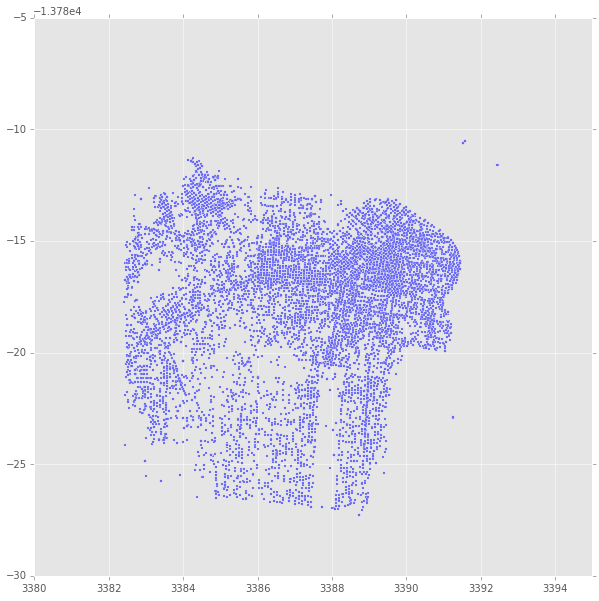

In [58]:
# change into meters
# pair_coordinates = [[item[0]*89.7, item[1]*112.7] for item in pair_coordinates]
# create scater plot
lat = train_df_new.Y*89.7
long = train_df_new.X*112.7
category_cluster = train_df_new.Category
# set axes range
plt.xlim(3380, 3395)
plt.ylim(-13810, -13785)
plt.scatter(lat, long, marker=u'.')

### Apply Mini Batch ###

** first, zip lat and long into list for clustering **

In [59]:
pair_coordinates = list(zip(lat,long))
# lat = raw_sfpd.Y*89.7
# long = raw_sfpd.X*112.7
pair_coordinates[:2]

[(3386.8339002919597, -13799.45930667832),
 (3391.1779266849935, -13795.922982963099)]

** two functions **
* mbk_time only outputs time... to find optimal batch size given cluster size 3 in the example
* optimal_mbk_time uses optimal batch size and cluster to output desired variables

In [60]:
# create mini batch function that takes clustersize and batchsize as parameters
def mbk_time(cluster_size, batch_size):
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=cluster_size, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
    t0 = time.time()
    mbk.fit(pair_coordinates)
    t_mini_batch = time.time() - t0
    return t_mini_batch

# create mini batch function that takes clustersize and batchsize as parameters
def optimal_mbk_time(cluster_size, batch_size):
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=cluster_size, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
    t0 = time.time()
    mbk.fit(pair_coordinates)
    t_mini_batch = time.time() - t0
    mbk_means_labels = mbk.labels_
    mbk_means_cluster_centers = mbk.cluster_centers_
    mbk_means_labels_unique = np.unique(mbk_means_labels)
    return t_mini_batch, mbk_means_labels, mbk_means_cluster_centers, mbk_means_labels_unique

** find optimal cluster size by using for loop **

In [61]:
mbk_means_batch = []
x = 100
while x < 10000:
    mbk_means_batch.append((x,round(mbk_time(cluster_size=3, batch_size=x),2)))
    x += 200

In [62]:
mbk_means_batch[:2]

[(100, 0.07), (300, 0.07)]

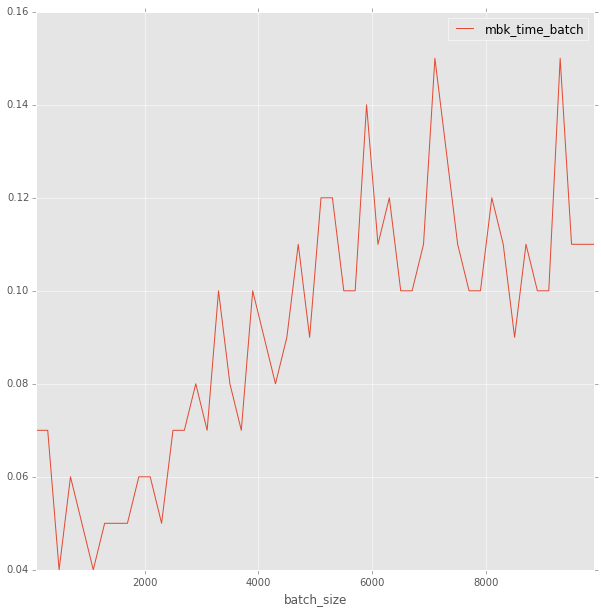

In [63]:
# plot optimal max batch size
mbk_batch_df = pd.DataFrame(mbk_means_batch)
mbk_batch_df.columns = ['batch_size', 'mbk_time_batch']
mbk_batch_df.plot(x = 'batch_size',y = 'mbk_time_batch')

In [64]:
# minimum batch around 3000
min_batch = mbk_batch_df['batch_size'][mbk_batch_df['mbk_time_batch']==mbk_batch_df['mbk_time_batch'].min()].values
print(min_batch)

[ 500 1100]


** apply clusters **

In [65]:
optimal_time, optimal_labels, optimal_centers, optimal_unique_labels = optimal_mbk_time(200,3000)

In [66]:
full_list = list(zip(optimal_labels, pair_coordinates, category_cluster))

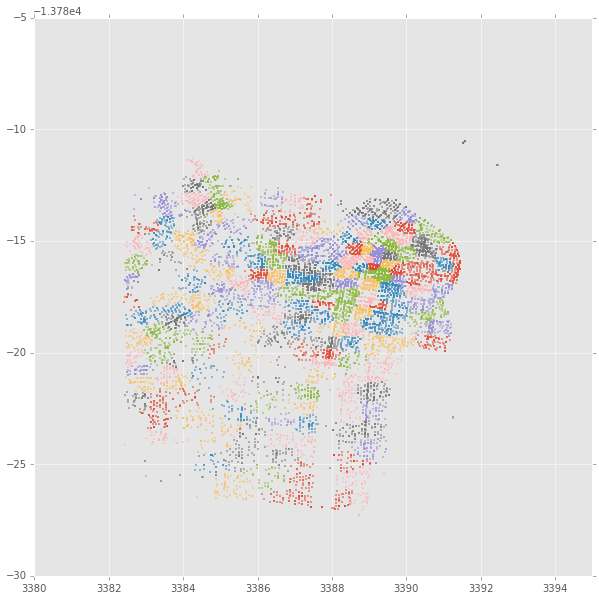

In [67]:
cluster_color = [item[0] for item in full_list ]
lat_mini = [item[1][0] for item in full_list]
long_mini = [item[1][1] for item in full_list]

# df = pandas.DataFrame(dict(lat_mini=lat_mini, long_mini=long_mini, cluster_color=cluster_color))

# #df = pandas.DataFrame(lat_mini=lat_mini, long_mini=long_mini, cluster_color=cluster_color)
# df.plot(kind='scatter', x='lat_mini', y='long_mini', color='DarkBlue')

df_clustering = pd.DataFrame(dict(lat_mini=lat_mini, long_mini=long_mini, cluster_color=cluster_color, category=category_cluster))

groups = df_clustering.groupby('cluster_color')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.lat_mini, group.long_mini, marker='.', linestyle='', ms=2, label=name)
#ax.legend()
plt.xlim(3380, 3395)
plt.ylim(-13810, -13785)
plt.show()

In [68]:
df_clustering.head()

,category,cluster_color,lat_mini,long_mini
0,ASSAULT,3,3386.833900,-13799.459307
1,LARCENY/THEFT,141,3391.177927,-13795.922983
2,LARCENY/THEFT,192,3387.229847,-13798.441416
3,LARCENY/THEFT,92,3389.994575,-13797.523729
4,DRUG/NARCOTIC,147,3389.097892,-13796.248818


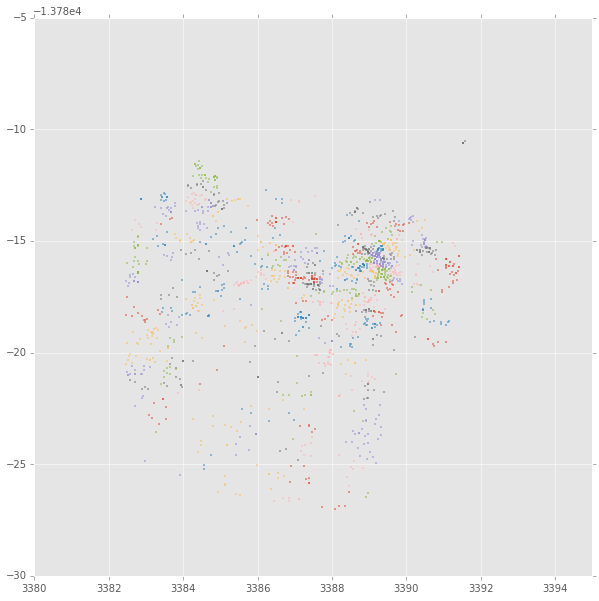

In [69]:
df_clustering2 = pd.DataFrame(dict(lat_mini=lat_mini, long_mini=long_mini, cluster_color=cluster_color, category=category_cluster))
df_clustering2 = df_clustering2[df_clustering2.category=="ASSAULT"]

groups2 = df_clustering2.groupby('cluster_color')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups2:
    ax.plot(group.lat_mini, group.long_mini, marker='.', linestyle='', ms=2, label=name)
#ax.legend()
plt.xlim(3380, 3395)
plt.ylim(-13810, -13785)
plt.show()

### use format_sfpd to start predicting

In [70]:
train_df_new.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,month_of_year,...,TARAVAL,TENDERLOIN,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,dummy_Category
0,2003-04-02 13:00:00,ASSAULT,THREATS AGAINST LIFE,Wednesday,PARK,NONE,500 Block of CORBETT AV,-122.444182,37.757346,4,...,0,0,0,0,0,0,0,0,1,1
1,2011-12-15 16:15:00,LARCENY/THEFT,GRAND THEFT PICKPOCKET,Thursday,CENTRAL,NONE,300 Block of BAY ST,-122.412804,37.805774,12,...,0,0,0,0,0,0,1,0,0,16
2,2015-03-04 01:55:00,LARCENY/THEFT,GRAND THEFT FROM PERSON,Wednesday,MISSION,NONE,400 Block of CASTRO ST,-122.435150,37.761760,3,...,0,0,0,0,0,0,0,0,1,16
3,2008-08-19 22:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,NORTHERN,NONE,2000 Block of WASHINGTON ST,-122.427007,37.792582,8,...,0,0,0,0,0,0,0,1,0,16
4,2014-04-16 12:58:00,DRUG/NARCOTIC,SALE OF BASE/ROCK COCAINE,Wednesday,TENDERLOIN,"ARREST, BOOKED",TURK ST / HYDE ST,-122.415695,37.782585,4,...,0,1,0,0,0,0,0,0,1,7


## Train on smaller dataset

In [71]:
train_df_new.shape

(20000, 47)

In [72]:
#training_data = format_sfpd[:10000]

In [73]:
#training_data.shape

In [74]:
train_df_new.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y', 'month_of_year', 'day_of_month',
       'hour_of_day', 'min_of_hour', 'WeekdayWeeekend', 'TimeOfDay', 'Season',
       'Year', 'Month', 'Hour', 'Weekday', 'Weekend', 'Afternoon', 'Midnight',
       'Morning', 'Night', 'Autumn', 'Spring', 'Summer', 'Winter', 'BAYVIEW',
       'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND',
       'SOUTHERN', 'TARAVAL', 'TENDERLOIN', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'dummy_Category'],
      dtype='object')

In [86]:
# Lat/Long
X_feature = (True, 'X')
Y_feature = (True, 'Y')

# Time
Month_feature = (False, 'month_of_year')
Day_feature = (False, 'day_of_month')
Hour_feature = (False, 'hour_of_day')
Min_feature = (False, 'min_of_hour')

# Day of Week
Friday_feature = (True, 'Friday') 
Monday_feature = (True, 'Monday')
Saturday_feature = (True, 'Saturday')
Sunday_feature = (True, 'Sunday')
Thursday_feature = (True, 'Thursday')
Tuesday_feature = (True, 'Tuesday')
Wednesday_feature = (True, 'Wednesday')

#Weekday/Weekend
Weekday_feature = (True, 'Weekday') 
Weekend_feature = (True, 'Weekend') 

#Season 
Autumn_feature = (True, 'Autumn') 
Spring_feature = (True, 'Spring') 
Summer_feature = (True, 'Summer') 
Winter_feature = (True, 'Winter') 

#Time of Day
Midnight_feature = (True, 'Midnight') 
Morning_feature = (True, 'Morning') 
Afternoon_feature = (True, 'Afternoon') 
Night_feature = (True, 'Night') 

# District
BAYV_feature = (True, 'BAYVIEW')
CENT_feature = (True, 'CENTRAL')
INGL_feature = (True, 'INGLESIDE')
MISS_feature = (True, 'MISSION')
NORT_feature = (True, 'NORTHERN')
PARK_feature = (True, 'PARK')
RICH_feature = (True, 'RICHMOND')
SOUT_feature = (True, 'SOUTHERN')
TARA_feature = (True, 'TARAVAL')
TEND_feature = (True, 'TENDERLOIN')

In [87]:
#feature_list = [X_feature, Y_feature, Monday_feature, Day_feature, Hour_feature, Min_feature,
#               Friday_feature, Monday_feature, Saturday_feature, Sunday_feature, Thursday_feature,
#               Tuesday_feature, Wednesday_feature, BAYV_feature, CENT_feature, INGL_feature,
#               MISS_feature, NORT_feature, PARK_feature, RICH_feature, SOUT_feature, TARA_feature, 
#               TEND_feature]

feature_list = [X_feature, Y_feature,
                Monday_feature, Day_feature, Hour_feature, Min_feature,
                Friday_feature, Monday_feature, Saturday_feature, Sunday_feature, Thursday_feature,
                Tuesday_feature, Wednesday_feature,Weekday_feature, Weekend_feature, Autumn_feature, Spring_feature,
                Summer_feature, Winter_feature, Midnight_feature, Morning_feature, Afternoon_feature,
                Night_feature, BAYV_feature, CENT_feature, INGL_feature,
                MISS_feature, NORT_feature, PARK_feature, RICH_feature, SOUT_feature, TARA_feature, 
                TEND_feature]

features = [str(x[1]) for x in feature_list if x[0]]
features

['X',
 'Y',
 'Monday',
 'Friday',
 'Monday',
 'Saturday',
 'Sunday',
 'Thursday',
 'Tuesday',
 'Wednesday',
 'Weekday',
 'Weekend',
 'Autumn',
 'Spring',
 'Summer',
 'Winter',
 'Midnight',
 'Morning',
 'Afternoon',
 'Night',
 'BAYVIEW',
 'CENTRAL',
 'INGLESIDE',
 'MISSION',
 'NORTHERN',
 'PARK',
 'RICHMOND',
 'SOUTHERN',
 'TARAVAL',
 'TENDERLOIN']

In [88]:
# features = ['X', 'Y', 'month_of_year', 'day_of_month',
#             'hour_of_day', 'min_of_hour', 'Friday', 'Monday', 'Saturday', 'Sunday',
#             'Thursday', 'Tuesday', 'Wednesday']

## SVM

**1) svm with single fold**

In [89]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(
    train_df_new[features], train_df_new['dummy_Category'], test_size=0.2, random_state=0)

In [90]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(16000, 30)
(4000, 30)
(16000,)
(4000,)


In [96]:
y_train.head()

17815    27
18370    31
1379     12
14763    26
7346     20
Name: dummy_Category, dtype: int64

In [97]:
#KNN - gives lowest error; does well with tons of data; ratio does not go to infiniti; data, ratio, (30 max)
# extra features on day: holiday; weekend; weekday; time of year; but do exploratory analyssi to find best features
# randomforest and decision tree will tell you the importance of feature
# 2D kernel density estimation

svc_model = svm.SVC(kernel = 'rbf', C=10.0).fit(x_train, y_train)

svc_model.score(x_test, y_test) 

0.24399999999999999

**2) svm with crossfolds**

In [81]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(16000, 22) (16000,)
(4000, 22) (4000,)


In [82]:
x_train.columns

Index(['X', 'Y', 'Weekday', 'Weekend', 'Autumn', 'Spring', 'Summer', 'Winter',
       'Midnight', 'Morning', 'Afternoon', 'Night', 'BAYVIEW', 'CENTRAL',
       'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN',
       'TARAVAL', 'TENDERLOIN'],
      dtype='object')

In [83]:
print(train_df_new[features].shape)
print(train_df_new['dummy_Category'].shape)

(20000, 22)
(20000,)


In [84]:
svm_2 = svm.SVC(kernel = 'rbf', C=90.0)
scores = cross_validation.cross_val_score(
    svm_2, train_df_new[features], train_df_new['dummy_Category'], cv=5)
scores

/Users/carlo_liquido/anaconda/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


array([ 0.22366127,  0.22815776,  0.22888556,  0.2244489 ,  0.22007528])

In [ ]:
SVM_tuned_parameters = [{'kernel': ['rbf'],
                     'gamma': [1e-1, 1e-2, 1e-3, 1e-4], 'C': [1, 10, 50, 100, 500, 1000]}
                   ]

SVM_scores = ['precision', 'recall']

In [ ]:
print(SVM_tuned_parameters)
print(SVM_scores)

In [ ]:
for score in SVM_scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.SVC(C=1), SVM_tuned_parameters, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

## KNN

In [85]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train) 
# KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
#            metric_params=None, n_jobs=1, n_neighbors=5, p=2,
#            weights='uniform')
knn.score(x_test, y_test) 

# knn.predict(x_test)
# array([1, 2, 1, 0, 0, 0, 2, 1, 2, 0])
# y_test
# array([1, 1, 1, 0, 0, 0, 2, 1, 2, 0])

0.17899999999999999